In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from math import atan2, hypot # angle and dist
import os
%matplotlib inline
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

# 1. Training SVC Classifier

## 1.1 Load Images

In [2]:
def AppendImageInFolder(l, path):
    images_files = glob.glob(path + '/*.png')
    for image in images_files:
        l.append(image)    

cars = []
notcars = []
debug = []
for fn in ['GTI_Far', 'GTI_Left', 'GTI_MiddleClose', 'GTI_Right', 'KITTI_extracted']:
    AppendImageInFolder(cars, 'training_data/vehicles/'+fn)
for fn in ['Extras', 'GTI']:
    AppendImageInFolder(notcars, 'training_data/non-vehicles/'+fn)
AppendImageInFolder(debug, 'debug')
print(len(cars), len(notcars), len(debug))    

8792 8968 124


## 1.2 Image feature extraction

/home/yingweiy/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(7, 7, 2, 2, 13)
(7, 7, 2, 2, 13)
(7, 7, 2, 2, 13)
(7, 7, 2, 2, 13)
(7, 7, 2, 2, 13)
(7, 7, 2, 2, 13)
(7, 7, 2, 2, 13)


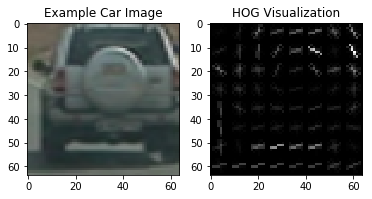

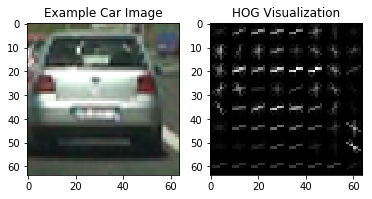

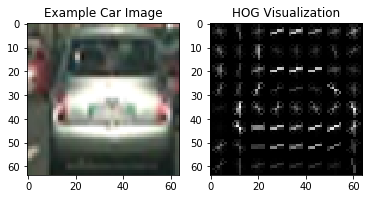

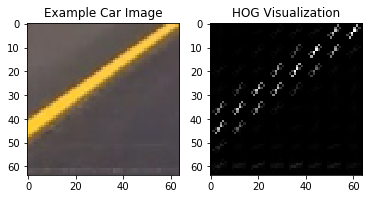

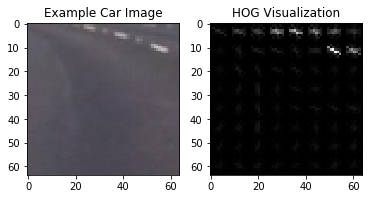

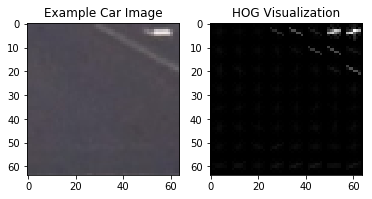

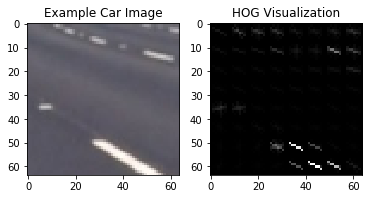

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    

def DisplayHOG(fn, gray=True):
    image = mpimg.imread(fn)
    # Define HOG parameters
    orient = 13
    pix_per_cell = 8
    cell_per_block = 2
    channel = 1
    
    if gray:
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)    
    else:
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,channel]
    # Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(feature_image, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    print(features.shape)

    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization')

# Read in the image
DisplayHOG('training_data/vehicles/GTI_MiddleClose/image0075.png')
DisplayHOG('training_data/vehicles/GTI_MiddleClose/image0105.png')
DisplayHOG('training_data/vehicles/GTI_MiddleClose/image0197.png')
DisplayHOG('training_data/non-vehicles/Extras/extra215.png')
DisplayHOG('training_data/non-vehicles/Extras/extra1061.png')
DisplayHOG('training_data/non-vehicles/Extras/extra1538.png')
DisplayHOG('training_data/non-vehicles/Extras/extra1525.png')


In [5]:
from lessonFunctions import *

color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 13
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'GRAY' # Can be 0, 1, 2, or "ALL"
hist_bins = 32
spatial_size=(32, 32)
spatial_feat = True
hist_feat = False
hog_feat = True


t=time.time()
car_features = extract_features(cars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
print(car_features.shape)
print(notcar_features.shape)

/home/yingweiy/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


21.39 Seconds to extract HOG features...
(8792, 5620)
(8968, 5620)


## 1.3 Data Preparation for training

In [6]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
#scaled_D = X_scaler.transform(np.array(debug_features))
scaled_NC = X_scaler.transform(np.array(notcar_features))

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 13 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5620


## 1.4 Classifier with SVC

In [7]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

12.88 Seconds to train SVC...
Test Accuracy of SVC =  0.9724


# 1.5 Customized SVC

In [102]:
def CustomizedSVC(spatial_feat, hist_feat, hog_feat):
    t=time.time()
    car_features = extract_features(cars, color_space=color_space, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_size=spatial_size,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_size=spatial_size,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    #scaled_D = X_scaler.transform(np.array(debug_features))
    scaled_NC = X_scaler.transform(np.array(notcar_features))

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    return svc, X_scaler

svc_spatial, X_scaler_spatial = CustomizedSVC(True, False, False)
svc_hist, X_scaler_hist = CustomizedSVC(False, True, False)
svc_hog, X_scaler_hog = CustomizedSVC(False, False, True)

19.72 Seconds to train SVC...
Test Accuracy of SVC =  0.8691


/home/yingweiy/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


1.48 Seconds to train SVC...
Test Accuracy of SVC =  0.8581


/home/yingweiy/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


6.86 Seconds to train SVC...
Test Accuracy of SVC =  0.953


# 2. Sliding Window and Classificaition

In [8]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='HSV', spatial_size=(32, 32),
                        hist_bins=32, orient=36, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=1,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'GRAY':
            gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            hog_features = get_hog_features(gray_image, orient,
                          pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        elif hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [9]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    off_windows = []
    #2) Iterate over all windows in the list
    cnt=1
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))   
        #mpimg.imsave('debug/patch_'+str(cnt).strip()+'.png', test_img, format='png')
        cnt+=1
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
        else:
            off_windows.append(window)
    #8) Return windows for positive detections
    return on_windows, off_windows

In [10]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    nx_windows = np.int((xspan - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int((yspan - ny_buffer) / ny_pix_per_step)    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [11]:
def DetectCar(fn, horizon_y=500):
    image = mpimg.imread(fn)

    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows32 = slide_window(image, x_start_stop=[400, 800], y_start_stop=[horizon_y, horizon_y+50], 
                        xy_window=(32, 30), xy_overlap=(0.5, 0.1))
    windows64 = slide_window(image, x_start_stop=[200, 1000], y_start_stop=[horizon_y, horizon_y+100], 
                        xy_window=(64, 60), xy_overlap=(0.5, 0.1))
    windows96 = slide_window(image, x_start_stop=[200, 1000], y_start_stop=[horizon_y, horizon_y+150], 
                        xy_window=(96, 70), xy_overlap=(0.5, 0.1))
    windows128 = slide_window(image, x_start_stop=[200, 1000], y_start_stop=[horizon_y, horizon_y+150], 
                        xy_window=(128, 86), xy_overlap=(0.5, 0.3))
    windows160 = slide_window(image, x_start_stop=[None, None], y_start_stop=[horizon_y, None], 
                        xy_window=(160, 110), xy_overlap=(0.5, 0.5))
    windows196 = slide_window(image, x_start_stop=[None, None], y_start_stop=[horizon_y, None], 
                        xy_window=(196, 110), xy_overlap=(0.5, 0.5))

    windows = windows32+windows64+windows96+windows128+windows160+windows196

    if False:
        hot_windows, off_windows = search_windows(image, windows, svc_spatial, X_scaler_spatial, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=True, 
                                hist_feat=False, hog_feat=False)                       
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=3)                    

        hot_windows, off_windows = search_windows(image, windows, svc_hist, X_scaler_hist, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=False, 
                                hist_feat=True, hog_feat=False)                       
        window_img = draw_boxes(window_img, hot_windows, color=(0, 255, 0), thick=3)                    

        hot_windows, off_windows = search_windows(image, windows, svc_hog, X_scaler_hog, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=False, 
                                hist_feat=False, hog_feat=True)                       
        window_img = draw_boxes(window_img, hot_windows, color=(255, 0, 0), thick=3)                    

    hot_windows, off_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=True, 
                            hist_feat=False, hog_feat=True)                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=2)  
    
    plt.figure(figsize=(18,12))
    plt.imshow(window_img)

/home/yingweiy/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


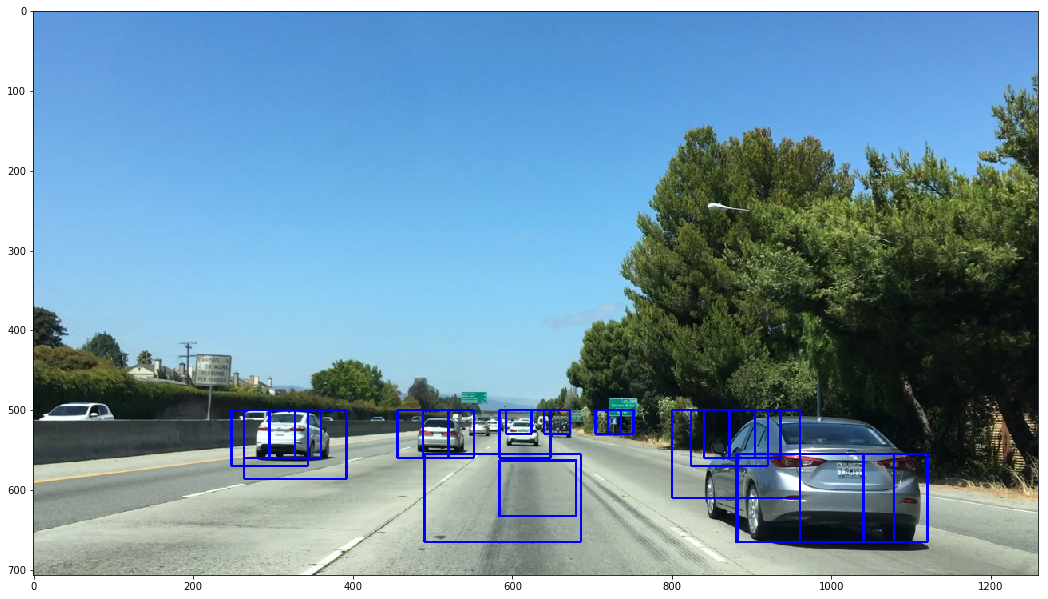

In [12]:
DetectCar('test_images/bbox-example-image.jpg')

/home/yingweiy/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


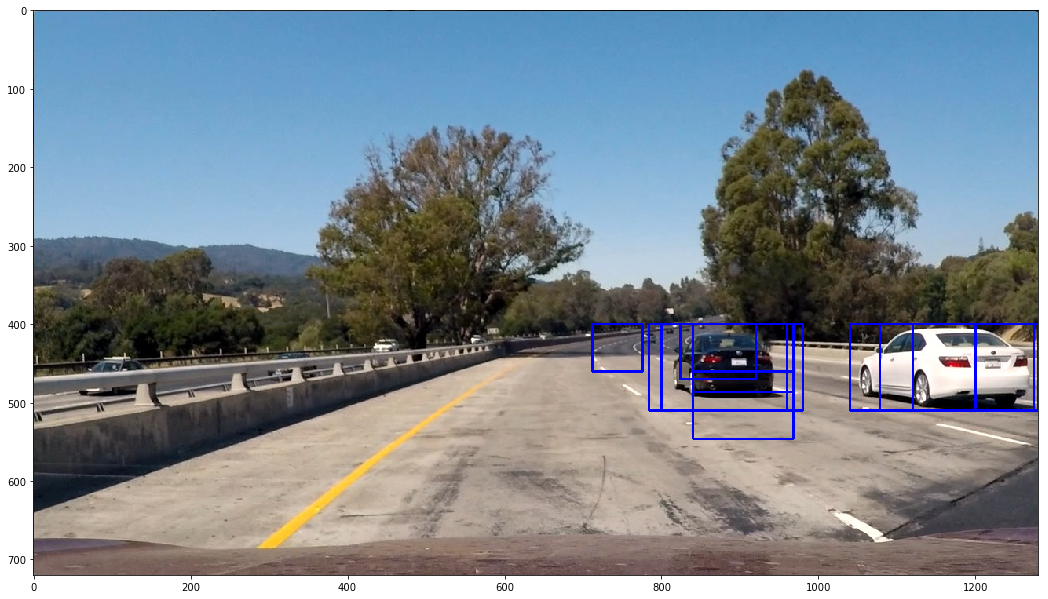

In [13]:
DetectCar('test_images/test1.jpg', horizon_y=400)

/home/yingweiy/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


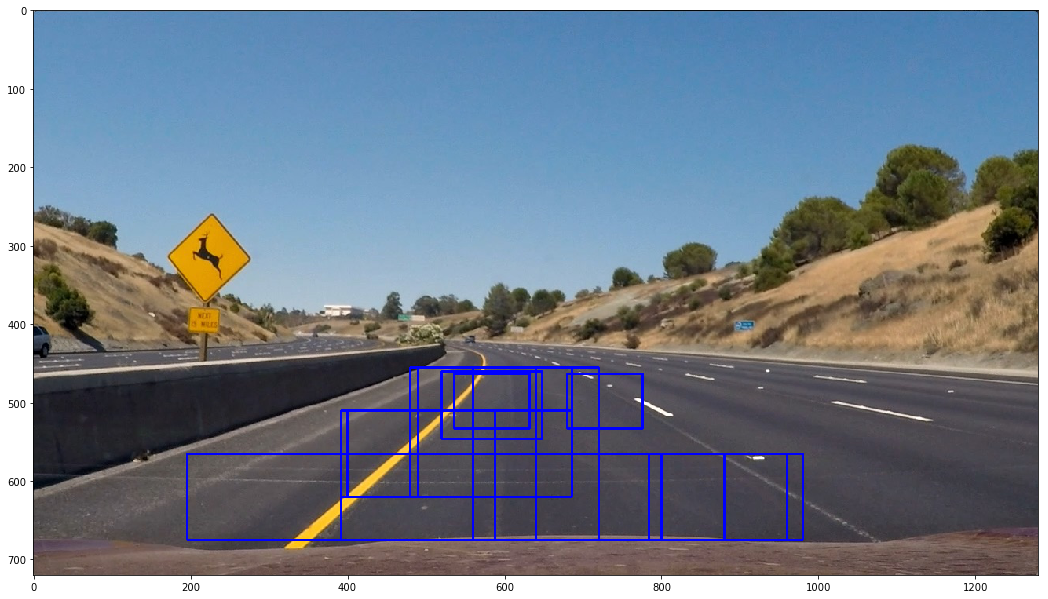

In [14]:
DetectCar('test_images/test2.jpg', horizon_y=400)

/home/yingweiy/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


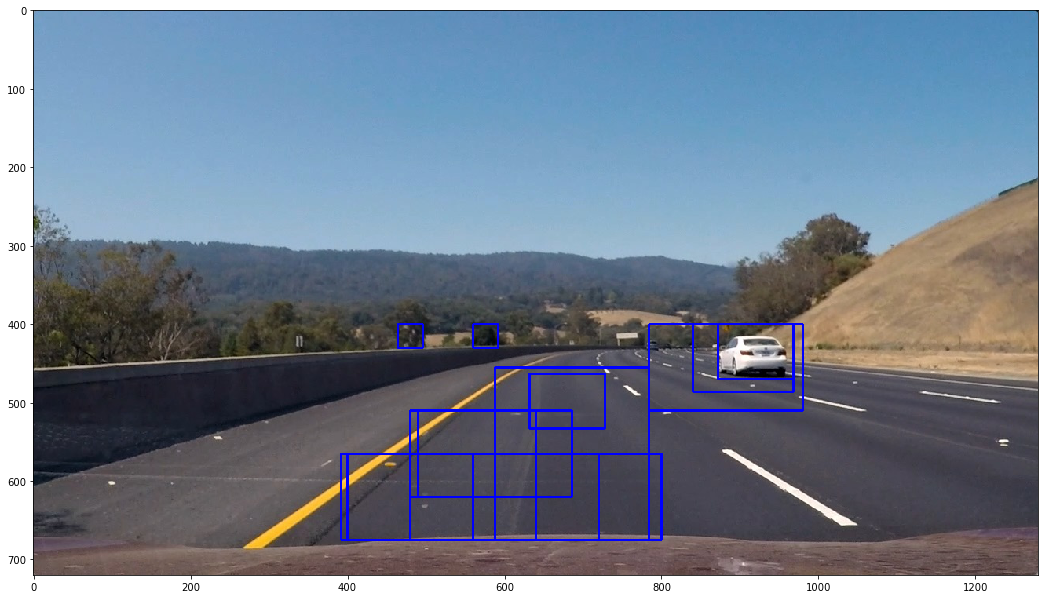

In [15]:
DetectCar('test_images/test3.jpg', horizon_y=400)

/home/yingweiy/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


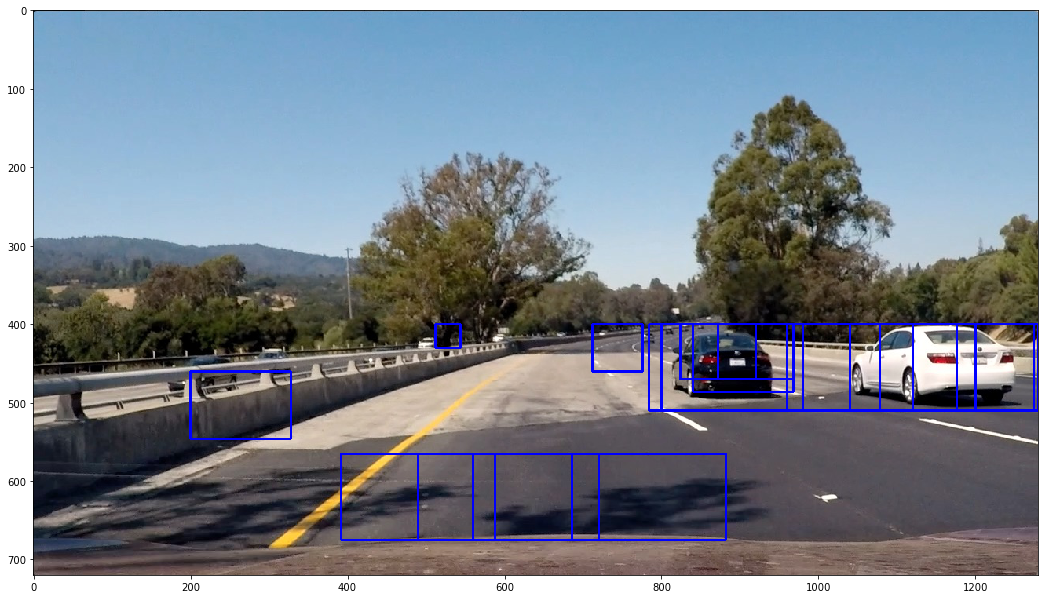

In [16]:
DetectCar('test_images/test4.jpg', horizon_y=400)

/home/yingweiy/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


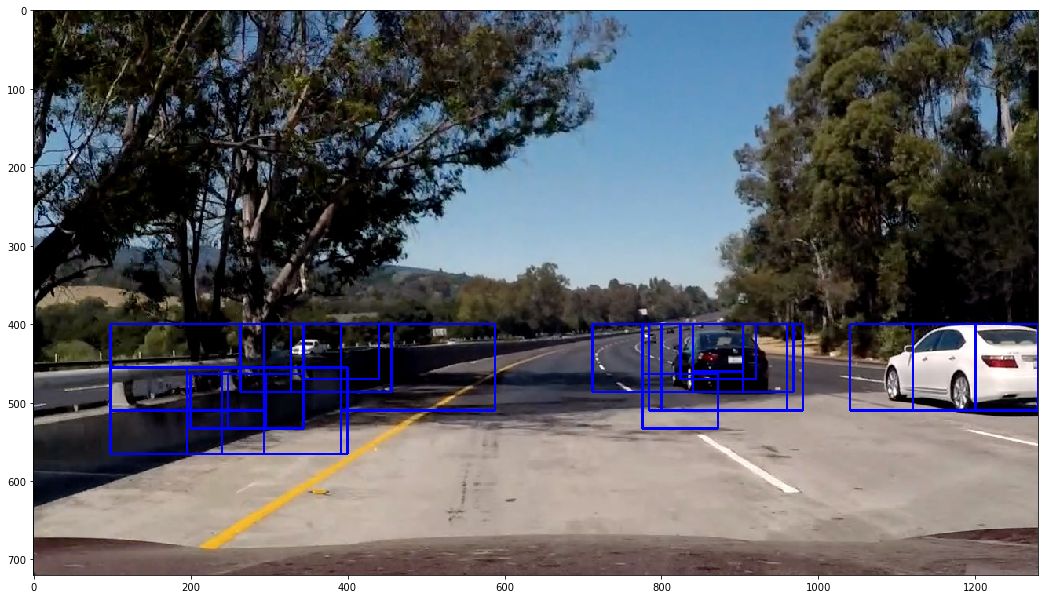

In [17]:
DetectCar('test_images/test5.jpg', horizon_y=400)

/home/yingweiy/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


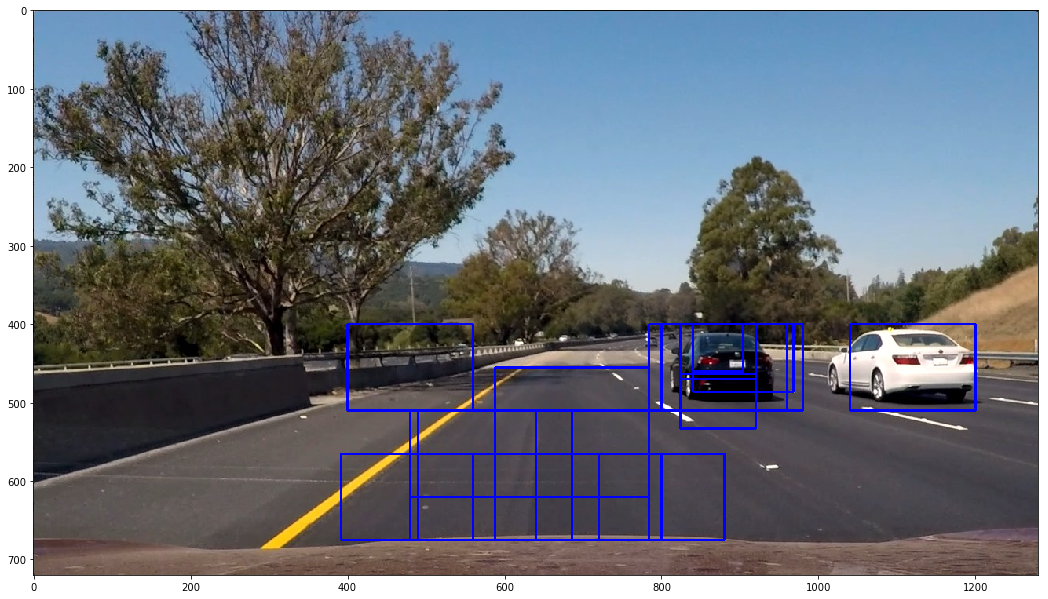

In [18]:
DetectCar('test_images/test6.jpg', horizon_y=400)